In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from itertools import count
from models.unet import unet
from settings import s
import time
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import dataloader
import json
from skimage import color
import matplotlib.pyplot as plt
from matplotlib import path
from color_discretizer import *

In [2]:
x=np.linspace(-110,110,9,True,dtype=int)
gridlab=np.vstack(map(np.ravel, np.meshgrid(x,x))).T
g=x*np.ones((1,len(x))).T
g=np.stack((g,np.rot90(g)))

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [258]:
spectrum = np.zeros([256,256*6, 3], dtype=np.uint8) # init the array
# fill the array with rgb values to create the spectrum without the use of loops
spectrum[:,:,0] = np.concatenate(([255]*256, np.linspace(255,0,256), [0]*256, [0]*256, np.linspace(0,255,256), [255]*256), axis=0)
spectrum[:,:,1] = np.concatenate((np.linspace(0,255,256), [255]*256, [255]*256, np.linspace(255,0,256), [0]*256,[0]*256), axis=0)
spectrum[:,:,2] = np.concatenate(([0]*256, [0]*256,np.linspace(0,255,256),[255]*256, [255]*256, np.linspace(255,0,256)), axis=0)
labspec=color.rgb2lab(spectrum/255)[0]

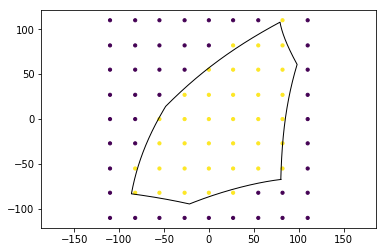

37


In [57]:
first = -110
size  = (110-first)/100

xv,yv = np.meshgrid(x,x)# np.meshgrid(np.linspace(-110,110,100),np.linspace(-110,110,100))
#p = path.Path([(-30,-10), (-50, 20), (10, 10), (30, 0)])  # square with legs length 1 and bottom left corner at the origin
p=path.Path(labspec[:,1:][::-1])
flags = p.contains_points(np.hstack((xv.flatten()[:,np.newaxis],yv.flatten()[:,np.newaxis])),radius=-15)
grid = np.zeros((101,101),dtype='bool')
grid[((xv.flatten()-first)/size).astype('int'),((yv.flatten()-first)/size).astype('int')] = flags

#xi,yi = np.random.randint(-300,300,100)/3,np.random.randint(-300,300,100)/3
xi,yi=gridlab[:,0],gridlab[:,1]
vflag = grid[((xi-first)/size).astype('int'),((yi-first)/size).astype('int')]
#plt.imshow(grid.T,origin='lower',interpolation='nearest',cmap='binary',extent=[-labspace.shape[1]*5., labspace.shape[1]*5., -labspace.shape[0]*5., labspace.shape[0]*5. ])
#plt.scatter(((xi-first)/size).astype('int'),((yi-first)/size).astype('int'),c=vflag,s=10)
plt.scatter(xi,-yi,c=vflag,s=10)
plt.axis('equal')
plt.plot(labspec[:,1],-labspec[:,2],color='k',lw=1)
plt.show()
print(np.count_nonzero(flags))

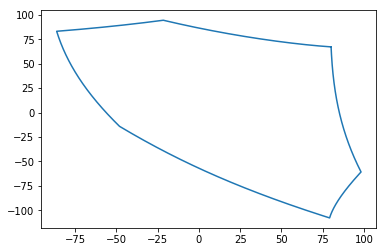

In [56]:
plt.plot(*labspec[:,1:].T)

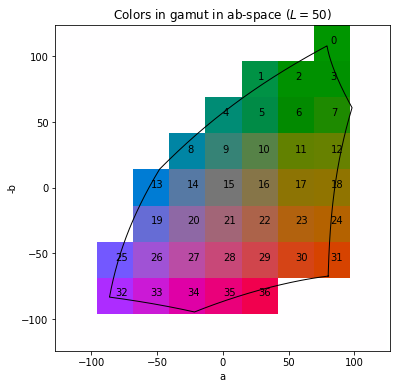

In [18]:
from skimage.transform import pyramid_expand
plt.figure(figsize=(6,6))
binsize=np.gradient(x).mean()
L=np.ones((1,len(x),len(x)))*50
labspace=np.concatenate((L,g)).transpose(2,1,0)
labspace=np.fliplr(labspace)
labspace_w=np.ones_like(labspace)*np.array([100,0,0]).reshape(1,1,3)
labspace_w[vflag.reshape(len(x),len(x))]=labspace[vflag.reshape(len(x),len(x))]
rgbrep=color.lab2rgb(pyramid_expand(labspace_w,binsize,0,0))
#rgbrep[rgbrep==np.zeros(3)]=np.ones_like(np.count_nonzero(rgbrep==np.zeros(3)))
plt.imshow(rgbrep,extent=[-labspace.shape[1]*binsize/2, labspace.shape[1]*binsize/2, -labspace.shape[0]*binsize/2, labspace.shape[0]*binsize/2 ])
#plt.plot(labspecfromxyz[:,1]+127,127+labspecfromxyz[:,2],color='k',lw=1)
plt.plot(labspec[:,1],-labspec[:,2],color='k',lw=1)
plt.axis('equal')
#plt.gca().grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.xlabel('a')
plt.ylabel('-b')
plt.title('Colors in gamut in ab-space $(L=%i)$'%L.flatten()[0])
#plt.savefig('figures/labgamut-bins.pdf')
bins=labspace[vflag.reshape(len(x),len(x))][:,1:]
for i in range(len(bins)):
    plt.text(bins[i][1],-bins[i][0],i)
plt.show()

In [19]:
bins=labspace[vflag.reshape(len(x),len(x))][:,1:]
len(bins)

37

In [20]:
torch.save(torch.from_numpy(bins),'resources/small_bins.pt')

In [21]:
bmap=np.ones((len(x),len(x)))*-1
bc=(bins*2/binsize).astype(int)
bmap[bc[:,0],bc[:,1]]=np.arange(len(bins))
torch.save(torch.from_numpy(bmap).long(),'resources/small_binmap.pt')

In [17]:
trainset = datasets.CIFAR10(root='./cifar-10', train=True,
                                    download=True, transform=transforms.ToTensor())

Files already downloaded and verified


In [26]:
im=plt.imread('places-small/Places365_val_00000417.jpg')/255
im = trainset.data[12]/255
lab=color.rgb2lab(im)
L=lab[:,:,:1]
Lten=torch.from_numpy(L.transpose((2,0,1))).unsqueeze(0)
abten=torch.from_numpy(lab[:,:,1:]).unsqueeze(0)

In [31]:
bins=torch.load('resources/small_bins.pt')

In [323]:
from importlib import reload
import functions
reload(functions)
yuv2bins=functions.yuv2bins

In [33]:
b=yuv2bins(abten.to('cuda')).cpu()
aa=bins[b.flatten()].reshape(1,b.shape[2],b.shape[2],2)
laa=np.concatenate((lab[:,:,0].reshape(1,32,32,1),aa),3)
reconstruction=color.lab2rgb(laa[0])

(-0.5, 63.5, 31.5, -0.5)

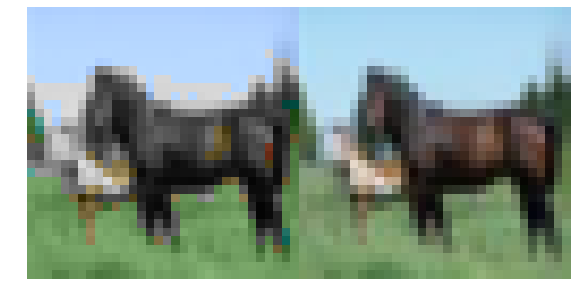

In [34]:
plt.figure(figsize=(10,5))
plt.imshow(np.hstack((reconstruction,im)))
plt.axis('off')

In [41]:
b[0,0,:,0]

tensor([14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 14, 14, 14,
        14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
        16, 16, 16, 10, 10, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
        11, 11, 11, 11, 10, 10, 11, 11, 11, 11, 11, 11, 10, 10, 11, 11, 11, 11,
        11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 11, 11, 11, 11, 11, 11,
        11, 10, 10, 10, 10, 11, 11, 11, 

In [2]:
cd=ColorDiscretizer()

In [3]:
cd.train('places-small/')

C:\Users\user\Desktop\6.Semester\Colorization\color_discretizer.py:115: RuntimeWarning: divide by zero encountered in log10
  logheatmap = np.log10(hm)
C:\Users\user\Desktop\6.Semester\Colorization\color_discretizer.py:132: RuntimeWarning: divide by zero encountered in log10
  logweights_matrix = np.log10(weights_matrix)


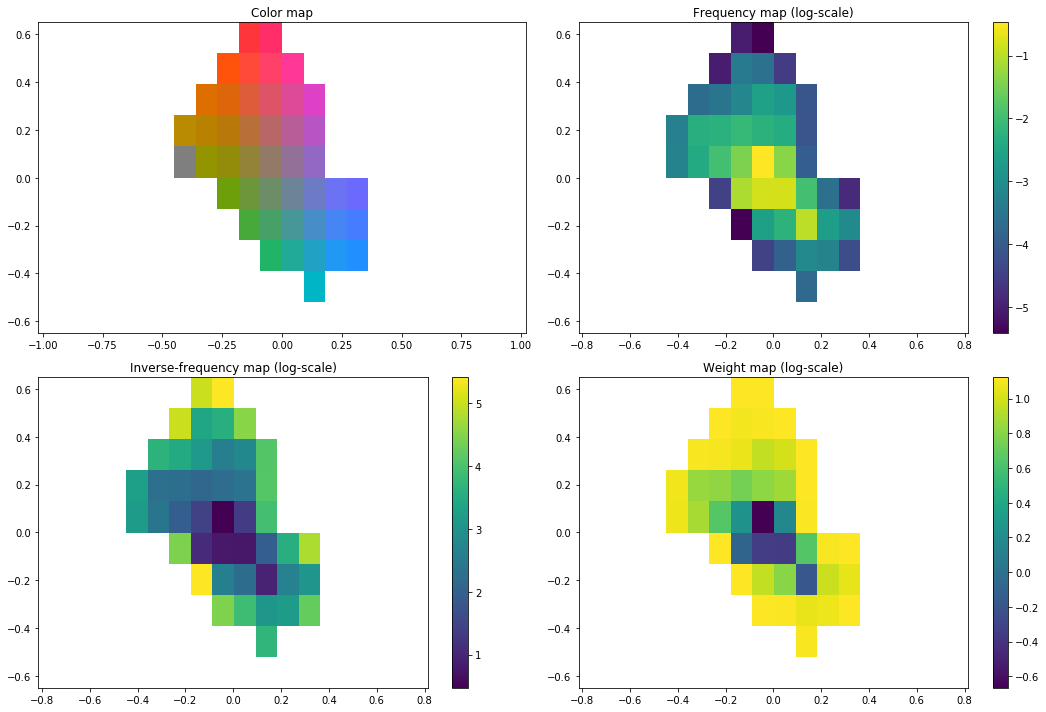

In [4]:
cd.plot_heatmap()

In [8]:
cm=cd.get_colormatrix()

In [12]:
cm.shape

(10, 10, 3)

In [128]:
X=np.random.random((700,2))*10
h,xe,ye=np.histogram2d(X[:,0],X[:,1],25)

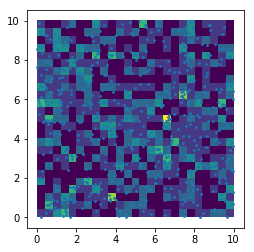

In [129]:
plt.imshow(np.rot90(h),extent=(xe.min(),xe.max(),ye.min(),ye.max()))#,extent=(0,10,10,0))
plt.scatter(*X.T,s=3)
#plt.scatter(200,150)

In [244]:
AB=[]

In [245]:
from tqdm import tqdm
#histogram for color rarity
#hist=dict(enumerate(np.zeros(len(bins))))
for i in tqdm(range(1,500)):
    #image=trainloader.dataset.data[i]
    try:
        image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        #image=trainloader.dataset.data[i]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image)
    AB.extend(labim[:,:,1:].reshape(-1,2).tolist())
    #used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    #for j in range(len(used_bins)):
    #    hist[used_bins[j]]+=1


100%|████████████████████████████████████████████████████████████████████████████████| 499/499 [00:31<00:00, 15.98it/s]


In [246]:
ab=np.array(AB)

In [247]:
H,xe,ye=np.histogram2d(ab[:,0],ab[:,1],10)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


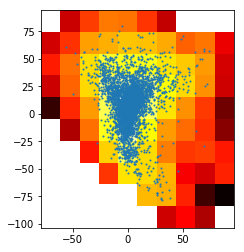

In [248]:
plt.imshow(np.rot90(np.log(H)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
plt.scatter(*ab[np.random.permutation(len(ab))][:6000].T,s=1)


In [249]:
numbin=32
Hpr=np.zeros_like(H)
thres=np.sort(H.flatten())[::-1][numbin]
Hpr[H>thres]=H[H>thres]

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


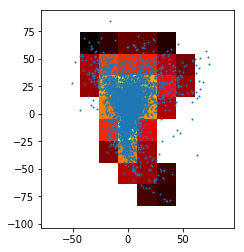

In [250]:
plt.imshow(np.rot90(np.log(Hpr)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
plt.scatter(*ab[np.random.permutation(len(ab))][:6000].T,s=1)


In [251]:
binsize=np.array([np.gradient(xe).mean(),np.gradient(ye).mean()])

In [313]:
def ind2ab(ind):
    x0=np.array([xe[0],ye[0]])
    return x0+ind*binsize#+binsize/2

In [314]:
x=np.arange(0,10)
coord=np.vstack(map(np.ravel, np.meshgrid(x,x))).T

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


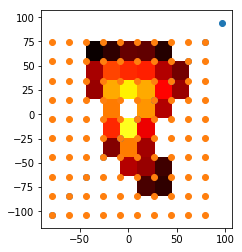

In [315]:
plt.imshow(np.rot90(np.log(Hpr)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
plt.scatter(xe,ye)
plt.scatter(*ind2ab(coord).T)

In [316]:
Habfull=ind2ab(coord).reshape(10,10,2)
Hab=np.zeros_like(Habfull)
Hab[H>thres]=Habfull[H>thres]
bins=Hab[Hab!=np.zeros(2)].reshape(-1,2)

In [317]:
vflag=H>thres

In [318]:
H.shape,x.shape,vflag.shape

((10, 10), (10,), (10, 10))

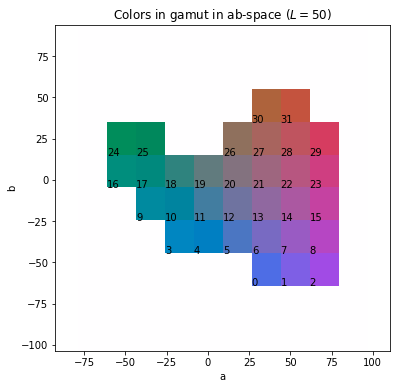

In [319]:
from skimage.transform import pyramid_expand
plt.figure(figsize=(6,6))
L=np.ones((len(x),len(x),1))*50
labspace=np.concatenate((L,Hab),axis=2)#.transpose(2,1,0)

labspace_w=np.ones_like(labspace)*np.array([100,0,0]).reshape(1,1,3)
labspace_w[vflag.reshape(len(x),len(x))]=labspace[vflag.reshape(len(x),len(x))]
rgbrep=color.lab2rgb(labspace_w)
rgbrep=np.flipud(rgbrep)
#rgbrep=np.rot90(rgbrep,-1);rgbrep=np.fliplr(rgbrep)
#rgbrep=color.lab2rgb(pyramid_expand(labspace_w,(),0,0))
#rgbrep[rgbrep==np.zeros(3)]=np.ones_like(np.count_nonzero(rgbrep==np.zeros(3)))
plt.imshow(rgbrep,extent=(xe.min(),xe.max(),ye.min(),ye.max()))
#plt.imshow(rgbrep,extent=[-labspace.shape[1]*binsize/2, labspace.shape[1]*binsize/2, -labspace.shape[0]*binsize/2, labspace.shape[0]*binsize/2 ])
#plt.plot(labspecfromxyz[:,1]+127,127+labspecfromxyz[:,2],color='k',lw=1)
#plt.plot(labspec[:,1],-labspec[:,2],color='k',lw=1)
plt.axis('equal')
#plt.gca().grid(which='minor', color='w', linestyle='-', linewidth=2)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Colors in gamut in ab-space $(L=%i)$'%L.flatten()[0])
#plt.savefig('figures/labgamut-bins.pdf')
bins=labspace[vflag.reshape(len(x),len(x))][:,1:]
for i in range(len(bins)):
    plt.text(bins[i][0],bins[i][1],i)
#plt.scatter(*bins.T)
plt.show()

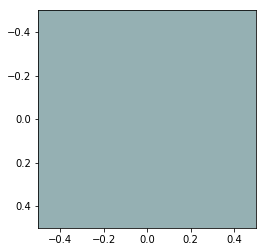

In [321]:
abc=bins[19]
plt.imshow(color.lab2rgb(np.array([70,abc[0],abc[1]]).reshape(1,1,3)))

In [322]:
abc

array([-8.47190577, -4.7687537 ])

In [324]:
from importlib import reload
import functions
reload(functions)
yuv2bins=functions.yuv2bins

In [329]:
trainset = datasets.CIFAR10(root='./cifar-10', train=True,
                                    download=True, transform=transforms.ToTensor())
im=plt.imread('places-small/Places365_val_00000417.jpg')/255
#im = trainset.data[12]/255
lab=color.rgb2lab(im)
L=lab[:,:,:1]
Lten=torch.from_numpy(L.transpose((2,0,1))).unsqueeze(0)
abten=torch.from_numpy(lab[:,:,1:]).unsqueeze(0)

Files already downloaded and verified


In [334]:
b=yuv2bins(abten,torch.unsqueeze(torch.from_numpy(bins),0))#.cpu()
aa=bins[b.flatten()].reshape(1,b.shape[2],b.shape[2],2)
laa=np.concatenate((lab[:,:,0].reshape(1,im.shape[1],-1,1),aa),3)
reconstruction=color.lab2rgb(laa[0])

(-0.5, 511.5, 255.5, -0.5)

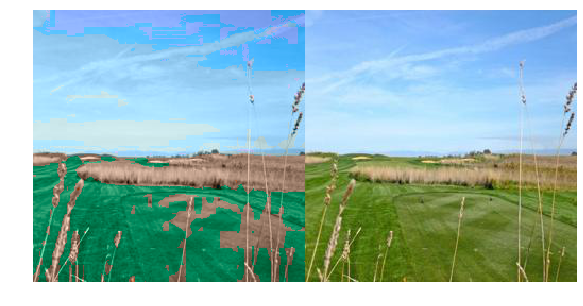

In [335]:
plt.figure(figsize=(10,5))
plt.imshow(np.hstack((reconstruction,im)))
plt.axis('off')